### Мазанов Артем

## Домашнее задание 1

Данное домашнее задание я разделил на 3 логические части: 

1) *Кроулинг сайта*

2) *Анализ графа сайта*

3) *Анализ текстов статей*

## Кроулинг сайта

Кроулинг сайта я делал с помощью **scrapy**. В архиве приложен проект с пауком **wiki_spider.py**, и его настройками **settings.py**. Собственно, паук обходил только сайты, начинающиеся с **https://simple.wikipedia.org/wiki/**, при этом игнорируя ссылки с *namespaces*, за исключением **Category**. Запоминал пройденные страницы, запоминал соответствия для файла **urls**. В конце работы он записывал файл **urls.txt**, в папке **docs** скачанные странице. 

## Анализ текста

В этом файле я выделяю текст в статьях для последующего анализа. Для этого мы проигнорируем страницы с **"Category:"** в url, так как это страницы со ссылками, не содержащие текста, но для создания графа они необходимы. Для получения текста из страниц уберем таблицы (это спорный момент, но я решил убрать их), описания фотографий, ссылки и выделим текст.

In [37]:
import requests
import os
from bs4 import BeautifulSoup


html_to_url = dict()
url_to_html = dict()

with open('urls.txt', 'r') as f:
    lines = f.read().split('\n')
    for line in lines:
        elems = line.split('\t')
        html_to_url[elems[0]] = elems[1]
        url_to_html[elems[1]] = elems[0]

for i, file_name in enumerate(os.listdir('docs')):
    if 'Category:' in html_to_url[file_name]:
        continue
    with open('docs/' + file_name, 'r') as f:
        soup = BeautifulSoup(f, 'lxml')
        soup = soup.find(id="mw-content-text")
        [elem.extract() for elem in soup.find_all('table')]
        [elem.extract() for elem in soup.find_all('div')]
        [elem.extract() for elem in soup.find_all('sup',{'class':'reference'})]
        [elem.extract() for elem in soup.find_all('span',{'class':'mw-editsection'})]
        text = u' '.join(soup.get_text().split()).encode('utf-8')
        path = file_name[:-5] + '.txt'
        with open('txt_docs/' + path, 'w') as ff:
            ff.write(text)

Получили папку **txt_docs** с .txt документами. Теперь соберем статистику по ним. Для начала построим гистограмму распределения размера документов:

In [56]:
sizes = list()
for i, file_name in enumerate(os.listdir('txt_docs')):
    sizes.append(float(os.path.getsize('txt_docs/' + file_name)) / 1024)

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

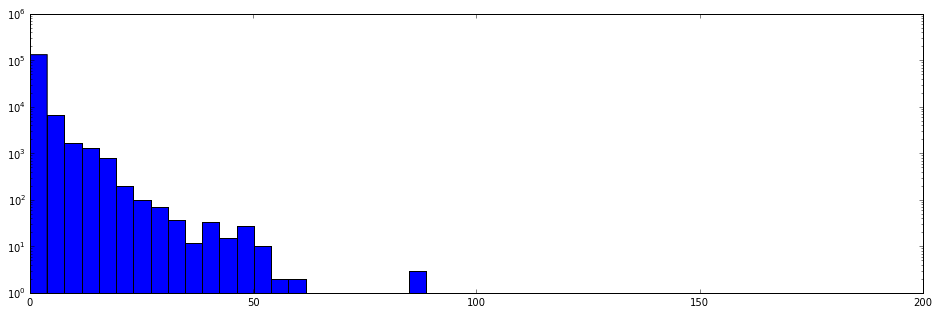

192.91015625


In [58]:
num_bins = 50
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(sizes, num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()
print max(sizes)

Далее посчитаем для каждого слова количество его вхождений в коллекцию и построим гистограмму:

In [72]:
import sys
import re

word_stat = dict()
for i, file_name in enumerate(os.listdir('txt_docs')):
    sys.stdout.write("\rProcessing {0}".format(i))
    with open('txt_docs/' + file_name, 'r') as f:
        words = re.findall(r'\b[a-z]+\b',f.read().lower()) 
        for word in words:
            if word_stat.get(word) is None:
                word_stat[word] = 1
            else:
                word_stat[word] += 1

Processing 142903

In [73]:
values = word_stat.values()

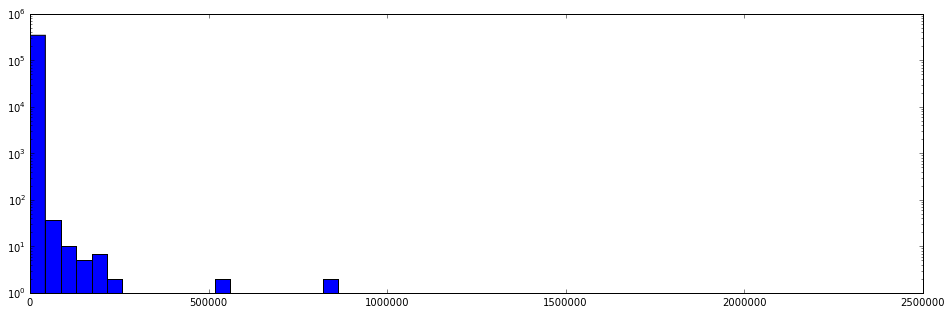

2156171


In [87]:
num_bins = 50
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(values, num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()
print max(values)

In [102]:
import operator
sorted_word_stat = sorted(word_stat.items(), key=operator.itemgetter(1), reverse = True)

In [105]:
for word, amount in sorted_word_stat[:20]:
    print word, amount

the 2156171
of 1074014
in 841986
and 819370
a 710329
to 553942
is 553261
was 333492
it 255385
for 230186
on 207897
are 205857
as 203299
he 194096
by 191568
that 187600
s 179212
with 163306
from 159930
at 143349


Как видно, есть несколько слов, которые встречаются **очень** часто и гистограмма очень малоинформативна. Поэтому отсечем хвосты и построим новую гистограмму:

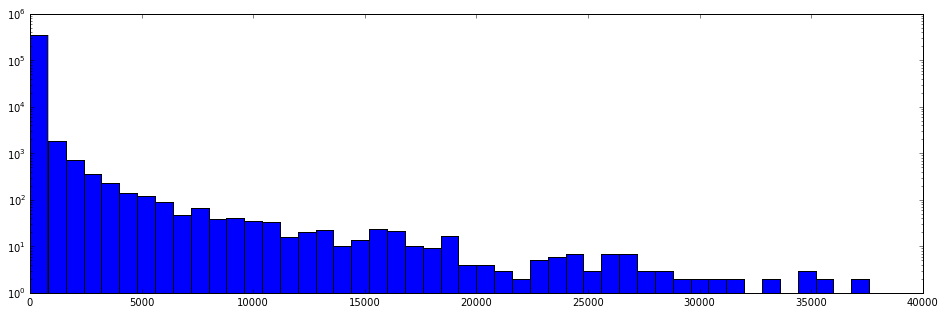

In [88]:
num_bins = 50
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(values, num_bins, facecolor='blue', range = (0, 40000))
plt.yscale('log', nonposy = 'clip')
plt.show()

Больше анализа текста не требуется. Анализ графа (in/out, расстояние от главной страницы и диаграмма распределения и PageRank) будут в следующем ipynb